# R基础绘图

https://mp.weixin.qq.com/s?__biz=MzAxMDkxODM1Ng==&mid=2247496689&idx=2&sn=2624aaf018d6f1e1cc0f4dc849599bb6

* 标题：A conserved dendritic-cell regulatory program limits antitumour immunity（一个保守的树突细胞调节程序限制抗肿瘤免疫）[nature](https://www.nature.com/articles/s41586-020-2134-y)

* DOI(url): 10.1038/s41586-020-2134-y

* 日期及杂志：Epub 2020 Mar 25，Nature

* 作者及单位：Miriam Merad，西奈山伊坎医学院（Icahn School of Medicine at Mount Sinai）

* 关键词：dendritic-cell，antitumour immunity

* 代码：https://github.com/effiken/Maier_et_al_nature_2020

Fig 1b, Fig 4a 看起来平平无奇的热图，很考验 R-base 作图的基本功。
https://github.com/effiken/Maier_et_al_nature_2020/blob/master/plot_figures/plot_1beg.R

微信号: https://mp.weixin.qq.com/s/N_sdyzbNwOg5jnmXbnLkig

## 造示例数据

一个表达矩阵 counts matrix;

一个表型数据 cellInfo data frame;

### counts matrix

In [1]:
# 造数据
set.seed(1)
getExpData=function(nCol=10){ #模拟数据，返回20行 n列矩阵
    exps=c()
    for(i in 1:nCol){
        tmp= rbinom(20, 30, 0.1)  #用二项分布模拟基因表达值，范围[1,30]
        
        # 随机归零，制造一个对角线附近比较大的矩阵
        random0=rep(0, 20)
        if( i < (nCol/3-1) ){ 
            random0[1:6]=1 
        }else if(i > nCol/3*2){
            random0[15:20]=1
        }else{
            random0[7:14]=1
        }
        
        noise=abs(rnorm(20, 0, 1)) #添加随机干扰
        exps=c(exps, tmp*random0 + noise)
    }
    matrix(exps, nrow=20) #20行 n列 
}

# 获取数据
mat=getExpData(10)
mat[mat > 4] <- 4 #大于4的改为4
mat=as.data.frame( apply( mat, 2, function(x){ x/sum(x)} )) #归一化

min(mat)
max(mat)

colnames(mat)=paste0("cell", 1:ncol(mat))
rownames(mat)=paste0("gene", 1:nrow(mat))

gene_list=rownames(mat)

dim(mat) #20行 n列
mat[1:3,]

[1] 6.580775e-05

[1] 0.144107

[1] 20 10

,cell1,cell2,cell3,cell4,cell5,cell6,cell7,cell8,cell9,cell10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
gene1,0.11711180,0.13628053,0.01686392,0.017766363,0.001527495,0.01291248,0.00574012,5.350221e-02,0.004647308,0.01434333
gene2,0.07969712,0.07677233,0.02517822,0.001206135,0.014952237,0.00724894,0.01302961,6.580775e-05,0.013890815,0.01468193
gene3,0.12076208,0.12595603,0.02165938,0.026087418,0.013494875,0.03215157,0.02371670,1.945656e-02,0.002376324,0.04770873


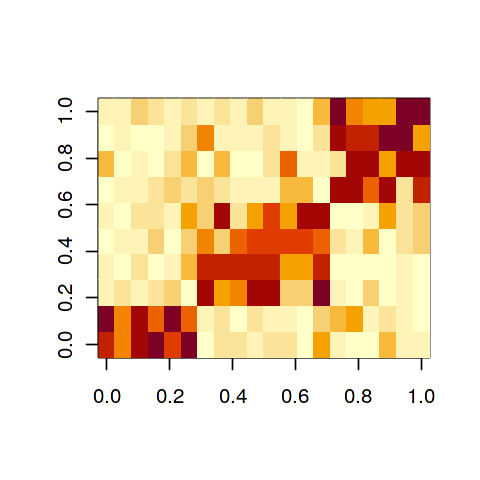

In [2]:
options(repr.plot.width=4, repr.plot.height=4)
image(as.matrix(mat))

### 表型df

In [3]:
cellInfo=data.frame(
    cid=paste0("cell",1: ncol(mat)),
    cellType=c("DC1","DC1", "DC2","DC2","DC2","DC2", "DC3","DC3","DC3","DC3"),
    sample=c("tumor","tumor","tumor","ctrl","tumor","tumor","tumor","ctrl","ctrl","tumor")
)
cellInfo=cellInfo[order(cellInfo$cellType),]
head(cellInfo)

,cid,cellType,sample
,<fct>,<fct>,<fct>
1,cell1,DC1,tumor
2,cell2,DC1,tumor
3,cell3,DC2,tumor
4,cell4,DC2,ctrl
5,cell5,DC2,tumor
6,cell6,DC2,tumor


### 绘图前的准备

In [4]:
# data
#df1=as.data.frame(table(cellInfo$cellType))
#df2=df1$Freq
#names(df2)=df1$Var1

df2=cellInfo

# 计算红线的位置
span=1/ (nrow(df2)-1) #每份宽度
breaks <- ( cumsum(table(df2$cellType))-0.5 ) *span #分界线的位置
breaks <- breaks[breaks<1]
print( breaks )


# 计算顶部文字x坐标
#mid_clusts <- (c(0,breaks)+c(breaks,1))/2 #原文不准确，两端并不是简单的0和1，而是分别外延0.5份。
mid_clusts <- (c(-0.5*span,breaks)+c(breaks,1+0.5*span))/2
mid_clusts

# 色彩
lin_col <- rgb(t(col2rgb(c(7,4,5)))*.7,max=255) #*0.7变暗
s <- seq(1,0,-1/49)

# 底部细胞来源
cell2sample =factor(cellInfo$sample)
head(cell2sample)
# 细胞类型
cell2annot=factor( cellInfo$cellType )
head(cell2annot)

      DC1       DC2 
0.1666667 0.6111111 


DC1        DC2 
0.05555556 0.38888889 0.83333333

[1] tumor tumor tumor ctrl  tumor tumor
Levels: ctrl tumor

[1] DC1 DC1 DC2 DC2 DC2 DC2
Levels: DC1 DC2 DC3

## 画图代码(优化过)

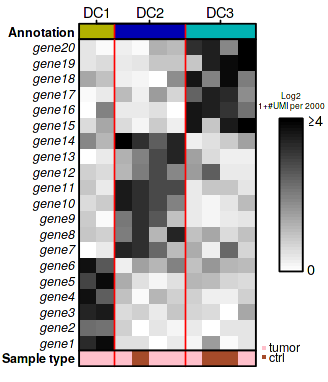

In [5]:
options(repr.plot.width=2.73, repr.plot.height=3.18, units="in") ##height=3.18,width=2.53,
# 使用layout函数，每个区域还设置了高度heighs和宽度widths
layout( matrix(1:6,nrow=3,ncol=2), widths=c(10,4), heights=c(.5,10,.5))
par(oma=c(1,5,1.5,.1)) # 使用了par设置oma，mar图的边距


#%%%%%%%%%%%%%%%%%%
# 第1列
#%%%%%%%%%%%%%%%%%%
#column 1
par(mar=c(0,0,0,0))

# pic1 热图
image( z=as.matrix(as.numeric(cell2annot)), xaxt="n", yaxt="n", col=lin_col)
box() #方框
abline(v=breaks, col="red") #红线
mtext(at=mid_clusts,c("DC1","DC2","DC3"),cex=.7,line=.25) #上方文字

mtext("Annotation",font=2,side=2,las=2,line=.25,cex=.6) #左边文字
axis(side=3,at=mid_clusts,labels=F,tck=-.2)

# pic2
# image绘制表达谱矩阵，使用了rgb设置颜色
image( z=t(log2(1+as.matrix(mat))), col=rgb(s,s,s), xaxt="n",yaxt="n")
box() # 矩阵外面添加盒子
abline(v=breaks,col="red") # 添加两条红色的直线

# 添加行基因名字
mtext(gene_list,side=2,at=seq(0,1,1/(length(gene_list)-1)),las=2,line=.25,font=3,cex=.6)


# pic3
par(mar=c(0,0,0,0))
image(z=as.matrix(as.numeric(factor(cell2sample,c("tumor","ctrl")))),
      col=c(rgb(255,192,203,max=255),rgb(165,75,42,max=255)),
      xaxt="n",yaxt="n")
abline(v=breaks,col="red")
box()
mtext("Sample type",font=2,side=2,las=2,line=.25,cex=.6)




#%%%%%%%%%%%%%%%%%%
# 第二列
#%%%%%%%%%%%%%%%%%%
par(mar=c(0,0,0,0)) # 设置绘图边距
plot.new() #第一行空着

# 第二行
par(mar=c(5,1.5,5,1.5))
image(t(matrix(1:50)),col=rgb(s,s,s),xaxt="n",yaxt="n")
box()
mtext(c("0","\u22654"),at=c(0,1),las=2,side=4,cex=.7,line=.25) #特殊符号 >=
mtext("Log2\n1+#UMI per 2000",side=3,line=.5,cex=.4)
#mtext("1+#UMI/2000",line=.5,cex=.5)

# 第三行
par(mar=c(0,0,0,0))
plot.new()
legend(x=0,y=1.8, legend = c("tumor","ctrl"),
       xpd=NA,
       y.intersp=1.5, #图形之间的高度差
       border=NA, #不要图例小方块描边
       cex=0.9, #图例缩放倍数
       bty="n", #不要图例的方框
       fill = c( rgb(255,192,203,max=255),rgb(165,75,42,max=255) ) )

# 分步骤解析

## 分割画布

首先，作者将此图划分成了3行2列的区域，然后在每个区域里使用基础绘图函数进行填充。

你没看错，这幅图里面的文字，方框，甚至坐标都是一个一个单独画进来的。

其实，这个很考验基本功，特别是**基础绘图函数**的坐标，有时候很难搞。

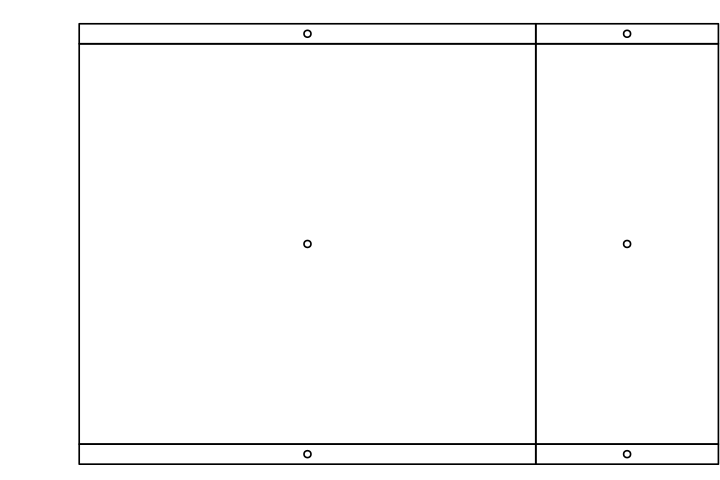

In [6]:
options(repr.plot.width=6, repr.plot.height=4)

layout( matrix(1:6,nrow=3,ncol=2), #竖着排列1-6，3行2列
       widths=c(10,4), #左右10：4
       heights=c(.5,10,.5)) #上下 0.5  10  0.5
#共6个区域，其中第二列4，5，6就画一个图例

# 使用了par设置oma，mar图的边距
par(oma=c(1,5,1.5,.1))
par(mar=c(0,0,0,0))

plot(c(1),xaxt="n",yaxt="n")
plot(c(2),xaxt="n",yaxt="n")
plot(c(3),xaxt="n",yaxt="n")

plot(c(4),xaxt="n",yaxt="n")
plot(c(5),xaxt="n",yaxt="n")
plot(c(6),xaxt="n",yaxt="n")

# 第一列

## col 1: row 1

然后绘制第一列的第一行区域
使用了par设置oma，mar图的边距

image绘制颜色格子，输入数据是一个矩阵，xaxt和yaxt设置不绘制坐标轴

box对图片绘图区域添加一个方框

abline添加颜色格子中间的两条红色的线

mtext添加行注释和列注释

axis再在颜色格子上方添加坐标刻度

### 生成颜色 

#### col2rgb()

In [7]:
col2rgb(10)

red,255
green,0
blue,0


In [8]:
#col2rgb #R color to RGB (red/green/blue) conversion.
col2rgb(c(7,4,5) )

red,255,0,0
green,255,0,255
blue,0,255,255


#### rgb()

In [9]:
# rgb(red, green, blue, alpha, names = NULL, maxColorValue = 1)
lin_col <- rgb(t(col2rgb(c(7,4,5)))*.7,max=255) #*0.7变暗
lin_col

[1] "#B2B200" "#0000B2" "#00B2B2"

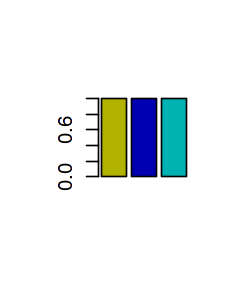

In [10]:
options(repr.plot.width=2, repr.plot.height=2.5)
barplot(rep(1,3), col=lin_col)

### image 热图

In [11]:
#造一个数据

set.seed(1)
df0=sign( round(rnorm(9,0,2)) )

df0=df0[order(df0)]
df0=matrix(df0, nrow=1)
df0

-1,-1,-1,0,1,1,1,1,1


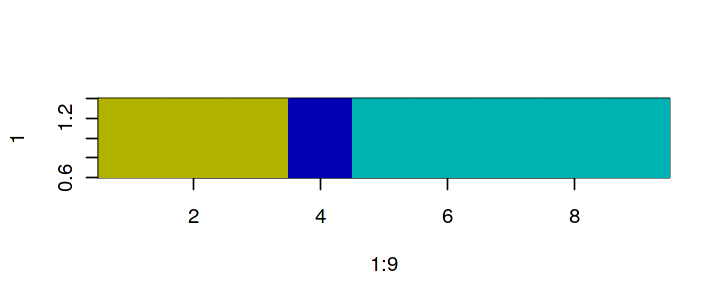

In [12]:
# 以(x,y)位置为中心画方框，深浅由矩阵 z 决定，颜色值col传入

options(repr.plot.width=6, repr.plot.height=2.5)

image( x=1:9, y=1, z=t(df0), col=lin_col )
#col: a list of colors such as that generated by hcl.colors, gray.colors or similar functions.

#### 分界线坐标怎么算？

之前总是不准，这一次分析明白。

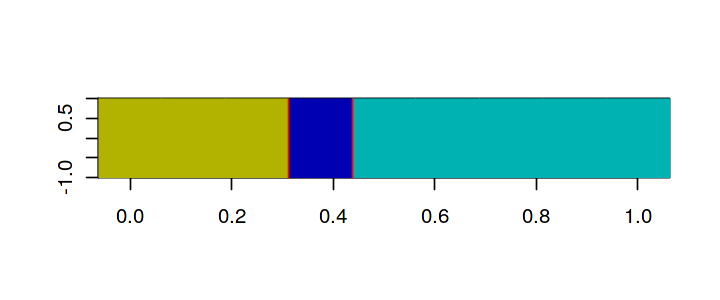

In [13]:
# 没有(x,y)则自动做(0,1)归一化
options(repr.plot.width=6, repr.plot.height=2.5)

image( z=t(df0), col=lin_col )

abline(v=c(2+0.5, 3+0.5)/8, col="red") #红线

  1   2   3 
0.1 0.3 0.7 


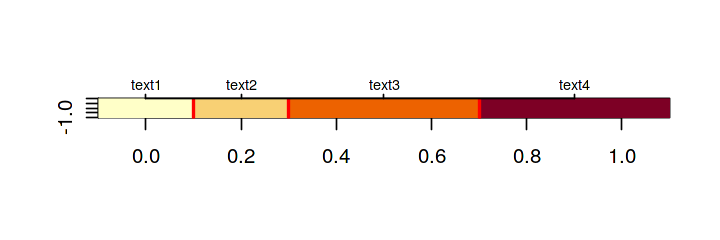

In [14]:
(function(){
    #1. 可见，在(0,1)之间，共3个方块，也就是 每份宽度 1/3；第一份右侧是0.5份
    df0=matrix(c(1,2,3,3,4,4), nrow=1)
    
    span=1/(ncol(df0)-1) #每份宽度
    breaks <- ( cumsum(table(df0[1,])) -0.5 ) *span #分界线的位置
    breaks <- breaks[breaks<1] #最右端的不要
    print(breaks)
    
    options(repr.plot.width=6, repr.plot.height=2) #jupyter 宽高
    image(z=t(df0))
    abline(v=breaks, col="red", lwd=2) #红线位置
    
    # 计算顶部文字x坐标，每份的中点
    mid_clusts <- (c(-0.5*span,breaks)+c(breaks,1+0.5*span))/2
    axis(side=3,at=mid_clusts,labels=F,tck=-.2)
    mtext(at=mid_clusts,c("text1","text2","text3","text4"),cex=.7,line=.25)
})()

### c1r1 效果图

    0     1 
0.125 0.625 


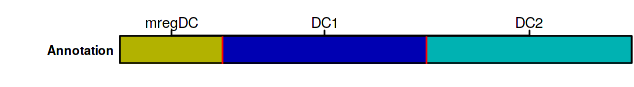

In [15]:
# section 1
options(repr.plot.width=6/14*10+1, repr.plot.height=4/15.5*0.5+0.6)
#options(repr.plot.width=6, repr.plot.height=4)

# 使用layout函数，每个区域还设置了高度heighs和宽度widths
#layout( matrix(1:6,nrow=3,ncol=2), widths=c(10,4), heights=c(.5,10,.5))
#
# 使用了par设置oma，mar图的边距
par(oma=c(1,5,1.5,.1))


#column 1
par(mar=c(0,0,0,0))


df2=matrix(c(0,1,1,2,2), ncol = 1)

# 计算红线的位置
span=1/(nrow(df2)-1) #每份宽度
breaks <- ( cumsum(table(df2[,1]))-0.5 ) *span #分界线的位置
breaks <- breaks[breaks<1]
print( breaks )
# 计算顶部文字x坐标
#mid_clusts <- (c(0,breaks)+c(breaks,1))/2 #原文不准确，两端并不是简单的0和1，而是分别外延0.5份。
mid_clusts <- (c(-0.5*span,breaks)+c(breaks,1+0.5*span))/2

# 主体热图
image( #x=0:nrow(df2), y=1, 
      z=df2, xaxt="n", yaxt="n", col=lin_col)
box() #方框
abline(v=breaks, col="red") #红线
mtext(at=mid_clusts,c("mregDC","DC1","DC2"),cex=.7,line=.25) #上方文字

mtext("Annotation",font=2,side=2,las=2,line=.25,cex=.6) #左边文字
axis(side=3,at=mid_clusts,labels=F,tck=-.2)

## 第一列第二行

接着，绘制第一列第2行灰色表达矩阵部分，依然使用了image，xart，yaxt，box，abline，metxt这些基础函数。这部分代码中有一个颜色rgb(s,s,s)值得收录一下。

In [16]:
s <- seq(1,0,-1/49)
s

[1] 1.000000e+00 9.795918e-01 9.591837e-01 9.387755e-01 9.183673e-01
 [6] 8.979592e-01 8.775510e-01 8.571429e-01 8.367347e-01 8.163265e-01
[11] 7.959184e-01 7.755102e-01 7.551020e-01 7.346939e-01 7.142857e-01
[16] 6.938776e-01 6.734694e-01 6.530612e-01 6.326531e-01 6.122449e-01
[21] 5.918367e-01 5.714286e-01 5.510204e-01 5.306122e-01 5.102041e-01
[26] 4.897959e-01 4.693878e-01 4.489796e-01 4.285714e-01 4.081633e-01
[31] 3.877551e-01 3.673469e-01 3.469388e-01 3.265306e-01 3.061224e-01
[36] 2.857143e-01 2.653061e-01 2.448980e-01 2.244898e-01 2.040816e-01
[41] 1.836735e-01 1.632653e-01 1.428571e-01 1.224490e-01 1.020408e-01
[46] 8.163265e-02 6.122449e-02 4.081633e-02 2.040816e-02 1.110223e-16

### scale() 列标准化

In [17]:
iris[seq(1,150,10),1:4]

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
,<dbl>,<dbl>,<dbl>,<dbl>
1,5.1,3.5,1.4,0.2
11,5.4,3.7,1.5,0.2
21,5.4,3.4,1.7,0.2
31,4.8,3.1,1.6,0.2
41,5.0,3.5,1.3,0.3
51,7.0,3.2,4.7,1.4
61,5.0,2.0,3.5,1.0
71,5.9,3.2,4.8,1.8
81,5.5,2.4,3.8,1.1


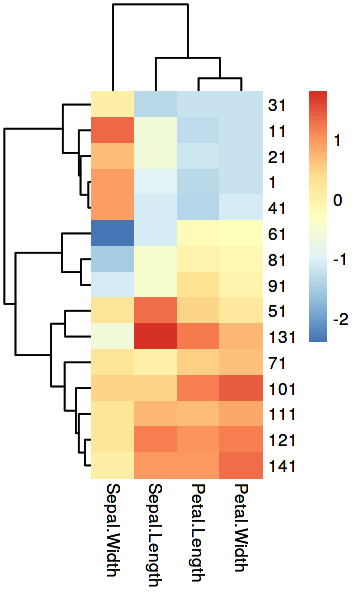

In [18]:
# 按照列做scale
rs=scale( iris[seq(1,150,10),1:4] )

library(pheatmap)
options(repr.plot.width=3, repr.plot.height=5)
p1=pheatmap( rs, border_color = "NA" ) #每列都有最值
p1

### image()效果

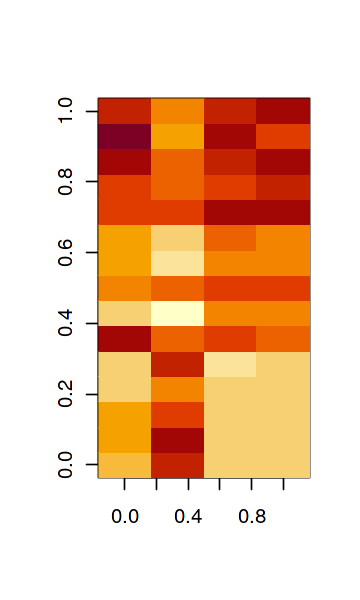

In [19]:
options(repr.plot.width=3, repr.plot.height=5)
image( t(scale( iris[seq(1,150,10),1:4] )) ) # mat第一行在图最底部

In [20]:
# 造数据
set.seed(1)
exps=c()
for(i in 1:500){
    tmp =rbinom(20, 1, 0.4) #随机0元素
    tmp= tmp * rbinom(20, 10, 0.1) 
    exps=c(exps, tmp)
}
mat= matrix(exps, nrow=20) #20行 ?列 

mat[mat > 4] <- 4

mat=apply( mat, 2, function(x){
    x/sum(x)
} )

min(mat)
max(mat)

dim(mat)
mat[1:3,]

[1] 0

[1] 1

[1]  20 500

0,0.2222222,0.0000000,0.25,0,0,0,0.0,0.3636364,0.0,⋯,0,0.000,0.00,0.0000000,0,0.07692308,0.07692308,0.125,0,0.0000000
0,0.0000000,0.1666667,0.00,0,0,0,0.0,0.0000000,0.0,⋯,0,0.125,0.75,0.1111111,0,0.15384615,0.07692308,0.000,0,0.1428571
0,0.1111111,0.0000000,0.00,0,0,0,0.2,0.0000000,0.2,⋯,0,0.125,0.00,0.0000000,0,0.07692308,0.00000000,0.000,0,0.0000000


In [21]:
gene_list=paste0("g", 1:nrow(mat) )
gene_list[1:10]

[1] "g1"  "g2"  "g3"  "g4"  "g5"  "g6"  "g7"  "g8"  "g9"  "g10"

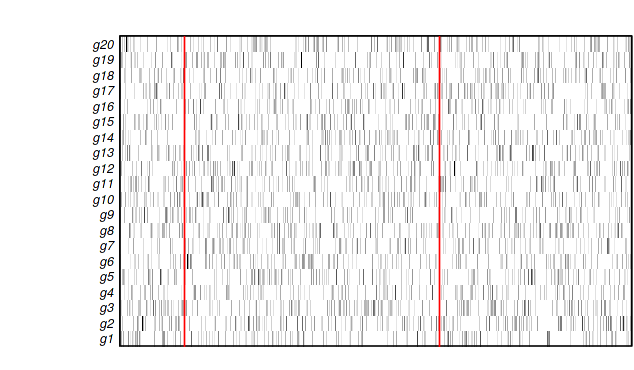

In [22]:
# section 2
options(repr.plot.width=6/14*10+1, repr.plot.height=4/15.5*10+0.5)

#options(repr.plot.width=6, repr.plot.height=4)
# 使用layout函数，每个区域还设置了高度heighs和宽度widths
#layout( matrix(1:6,nrow=3,ncol=2), widths=c(10,4), heights=c(.5,10,.5))
#
# 使用了par设置oma，mar图的边距
par(oma=c(1,5, 1.5, 0.1))


#%%%%%%%%%%%%%%%%%%%%%%%
# row1 占位符
par(mar=c(0,0,0,0))
#plot(c(1))


#%%%%%%%%%%%%%%%%%%%%%%%
#row2
# image绘制表达谱矩阵，使用了rgb设置颜色
image( t(log2(1+as.matrix(mat))), col=rgb(s,s,s), xaxt="n",yaxt="n")
box() # 矩阵外面添加盒子
abline(v=breaks,col="red") # 添加两条红色的直线

# 添加行基因名字
mtext(gene_list,side=2,at=seq(0,1,1/(length(gene_list)-1)),las=2,line=.25,font=3,cex=.6)

## 第一列第三行

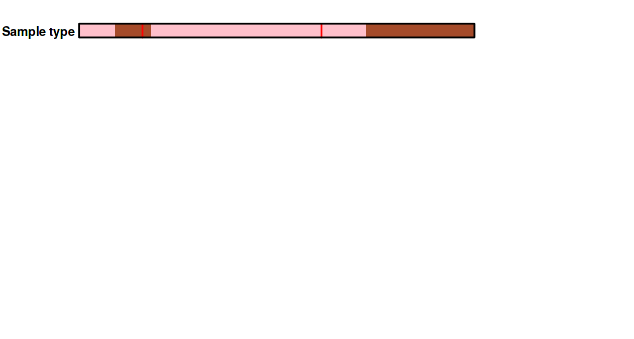

In [23]:
# section 3
options(repr.plot.width=6/14*10+1, repr.plot.height=0.5/15.5*10+2.5)

#options(repr.plot.width=6, repr.plot.height=4)
# 使用layout函数，每个区域还设置了高度heighs和宽度widths
layout( matrix(1:6,nrow=3,ncol=2), widths=c(10,4), heights=c(.5,10,.5))
#
# 使用了par设置oma，mar图的边距
par(oma=c(1,5, 1.5, 0.1))


#%%%%%%%%%%%%%%%%%%%%%%%
# row1 占位符
par(mar=c(0,0,0,0))
#plot(c(1))
#plot(c(1))


cell2sample =c("Naive","KP","Naive", "Naive", "Naive","Naive","Naive","Naive","KP","KP","KP")

par(mar=c(0,0,0,0))
image(as.matrix(as.numeric(factor(cell2sample,c("Naive","KP")))),
      col=c(rgb(255,192,203,max=255),rgb(165,75,42,max=255)),
      xaxt="n",yaxt="n")
abline(v=breaks,col="red")
box()
mtext("Sample type",font=2,side=2,las=2,line=.25,cex=.6)

# 第二列

## legend 间距

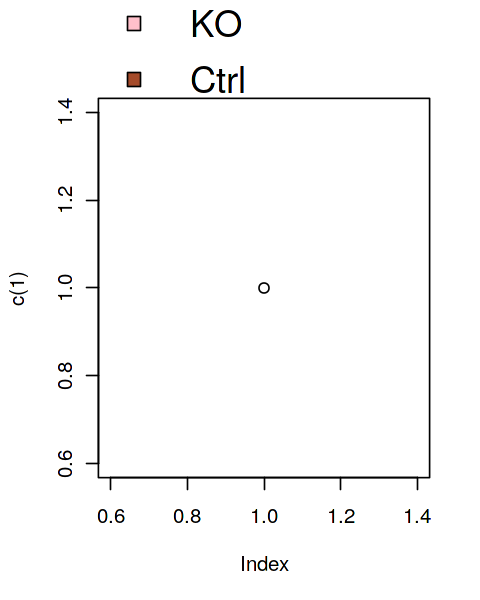

In [24]:
options(repr.plot.width=4, repr.plot.height=5)
plot(c(1))

legend(x=0.6,y=1.7,legend = c("KO","Ctrl"),
       xpd=T,
       
       y.intersp=2, #图形之间的y距离，高度差
       x.intersp=3, #图形和文字的x距离
       
       text.width=2, #两个图例之间的距离(这里没作用)
       
       cex=1.8, #图例缩放倍数
       bty="n", #不要图例的外方框
       #border=NA, #不要图例小方块描边
       
       fill = c( rgb(255,192,203,max=255),rgb(165,75,42,max=255) ) )

## legend 方块图例不要边框

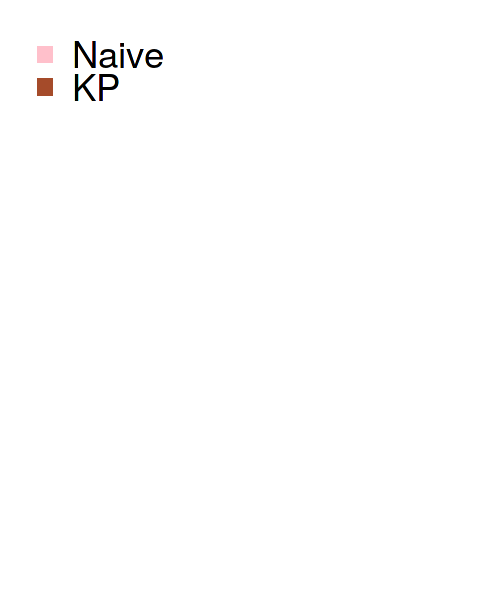

In [25]:
# 为什么没有颜色？
options(repr.plot.width=4, repr.plot.height=5)

par(mar=c(0,0,0,0))

plot.new()
legend(x=0,y=1, legend = c("Naive","KP"),
       xpd=NA,
       border=NA, #不要图例小方块描边
       cex=1.8, #图例缩放倍数
       bty="n", #不要图例的方框
       fill = c( rgb(255,192,203,max=255),rgb(165,75,42,max=255) ) )

## 正图

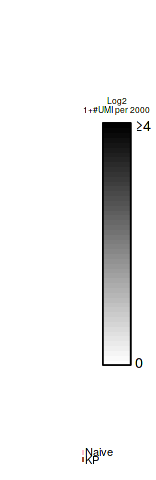

In [26]:
# section 4 5 6
options(repr.plot.width=1.3, repr.plot.height=4)
layout( matrix(1:3,nrow=3,ncol=1), widths=c(4), heights=c(.5,10,.5))

par(oma=c(1,5, 1.5, 0.1)) # 使用了par设置oma，mar图的边距
par(mar=c(0,0,0,0)) # 设置绘图边距
plot.new() #第一行空着

# 第二行
par(mar=c(5,1.5,5,1.5))
image(t(matrix(1:50)),col=rgb(s,s,s),xaxt="n",yaxt="n")
box()
mtext(c("0","\u22654"),at=c(0,1),las=2,side=4,cex=.7,line=.25) #特殊符号 >=
mtext("Log2\n1+#UMI per 2000",side=3,line=.5,cex=.4)
#mtext("1+#UMI/2000",line=.5,cex=.5)

# 第三行
par(mar=c(0,0,0,0))
plot.new()
legend(x=0,y=1, legend = c("Naive","KP"),
       xpd=NA,
       border=NA, #不要图例小方块描边
       cex=0.8, #图例缩放倍数
       bty="n", #不要图例的方框
       fill = c( rgb(255,192,203,max=255),rgb(165,75,42,max=255) ) )

# 合并后的图

In [27]:
# data
df2=matrix(c(0,1,1,2,2), ncol = 1)

# 计算红线的位置
span=1/(nrow(df2)-1) #每份宽度
breaks <- ( cumsum(table(df2[,1]))-0.5 ) *span #分界线的位置
breaks <- breaks[breaks<1]
print( breaks )


# 计算顶部文字x坐标
#mid_clusts <- (c(0,breaks)+c(breaks,1))/2 #原文不准确，两端并不是简单的0和1，而是分别外延0.5份。
mid_clusts <- (c(-0.5*span,breaks)+c(breaks,1+0.5*span))/2



cell2sample =c("Naive","KP","Naive", "Naive", "KP")

    0     1 
0.125 0.625 


In [28]:
# 造数据
set.seed(1)
exps=c()
for(i in 1:5){
    tmp =rbinom(20, 1, 0.4) #随机0元素
    tmp= tmp * rbinom(20, 10, 0.1) 
    exps=c(exps, tmp)
}
mat= matrix(exps, nrow=20) #20行 ?列 

mat[mat > 4] <- 4

mat=apply( mat, 2, function(x){
    x/sum(x)
} )

min(mat)
max(mat)

dim(mat) #20行 5列
mat[1:3,]

[1] 0

[1] 0.25

[1] 20  5

0,0.2222222,0.0000000,0.25,0
0,0.0000000,0.1666667,0.00,0
0,0.1111111,0.0000000,0.00,0


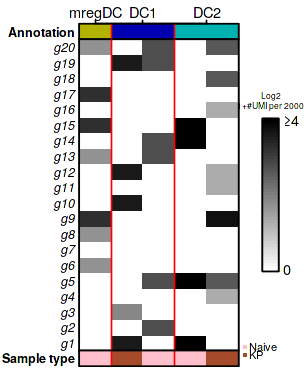

In [29]:
#png(paste0("fig1b.png"),height=3.18,width=2.53,units="in",res=1000)

options(repr.plot.width=2.53, repr.plot.height=3.18, units="in") ##height=3.18,width=2.53,
# 使用layout函数，每个区域还设置了高度heighs和宽度widths
layout( matrix(1:6,nrow=3,ncol=2), widths=c(10,4), heights=c(.5,10,.5))
par(oma=c(1,5,1.5,.1)) # 使用了par设置oma，mar图的边距


#%%%%%%%%%%%%%%%%%%
# 第1列
#%%%%%%%%%%%%%%%%%%
#column 1
par(mar=c(0,0,0,0))

# pic1 热图
image( #x=0:nrow(df2), y=1, 
      z=df2, xaxt="n", yaxt="n", col=lin_col)
box() #方框
abline(v=breaks, col="red") #红线
mtext(at=mid_clusts,c("mregDC","DC1","DC2"),cex=.7,line=.25) #上方文字

mtext("Annotation",font=2,side=2,las=2,line=.25,cex=.6) #左边文字
axis(side=3,at=mid_clusts,labels=F,tck=-.2)

# pic2
# image绘制表达谱矩阵，使用了rgb设置颜色
image( z=t(log2(1+as.matrix(mat))), col=rgb(s,s,s), xaxt="n",yaxt="n")
box() # 矩阵外面添加盒子
abline(v=breaks,col="red") # 添加两条红色的直线

# 添加行基因名字
mtext(gene_list,side=2,at=seq(0,1,1/(length(gene_list)-1)),las=2,line=.25,font=3,cex=.6)


# pic3
par(mar=c(0,0,0,0))
image(z=as.matrix(as.numeric(factor(cell2sample,c("Naive","KP")))),
      col=c(rgb(255,192,203,max=255),rgb(165,75,42,max=255)),
      xaxt="n",yaxt="n")
abline(v=breaks,col="red")
box()
mtext("Sample type",font=2,side=2,las=2,line=.25,cex=.6)




#%%%%%%%%%%%%%%%%%%
# 第二列
#%%%%%%%%%%%%%%%%%%
par(mar=c(0,0,0,0)) # 设置绘图边距
plot.new() #第一行空着

# 第二行
par(mar=c(5,1.5,5,1.5))
image(t(matrix(1:50)),col=rgb(s,s,s),xaxt="n",yaxt="n")
box()
mtext(c("0","\u22654"),at=c(0,1),las=2,side=4,cex=.7,line=.25) #特殊符号 >=
mtext("Log2\n1+#UMI per 2000",side=3,line=.5,cex=.4)
#mtext("1+#UMI/2000",line=.5,cex=.5)

# 第三行
par(mar=c(0,0,0,0))
plot.new()
legend(x=0,y=1.8, legend = c("Naive","KP"),
       xpd=NA,
       y.intersp=1.5, #图形之间的高度差
       border=NA, #不要图例小方块描边
       cex=0.8, #图例缩放倍数
       bty="n", #不要图例的方框
       fill = c( rgb(255,192,203,max=255),rgb(165,75,42,max=255) ) )

#dev.off()